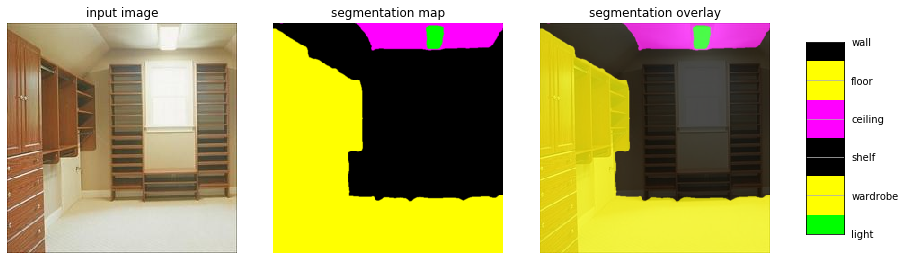

In [79]:
import requests
import json
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

#URL = 'http://143.248.94.189:35005/api/predict'
#URL = 'http://143.248.96.81:35005/api/predict'
URL = 'http://143.248.96.69:35005/api/predictIndex'
#URLGetColor = 'http://143.248.96.69:35005/api/colorMap'

def convertTuple(list): 
    return tuple(i for i in list) 

def create_ade20k_label_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

    return colormap

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_ade20k_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')
    return colormap[label]

def vis_segmentation(image, seg_map, seg_image):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    #seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

if __name__ == "__main__":
    LABEL_NAMES = np.array(['wall' ,'building' ,'sky' ,'floor' ,'tree' ,'ceiling' ,'road' ,'bed' ,'windowpane' ,'grass' ,'cabinet' ,'sidewalk' ,'person' ,'earth' ,'door' ,'table' ,'mountain' ,'plant' ,'curtain' ,'chair' ,'car' ,'water' ,'painting' ,'sofa' ,'shelf' ,'house' ,'sea' ,'mirror' ,'rug' ,'field' ,'armchair' ,'seat' ,'fence' ,'desk' ,'rock' ,'wardrobe' ,'lamp' ,'bathtub' ,'railing' ,'cushion' ,'base' ,'box' ,'column' ,'signboard' ,'chest of drawers' ,'counter' ,'sand' ,'sink' ,'skyscraper' ,'fireplace' ,'refrigerator' ,'grandstand' ,'path' ,'stairs' ,'runway' ,'case' ,'pool table' ,'pillow' ,'screen door' ,'stairway' ,'river' ,'bridge' ,'bookcase' ,'blind' ,'coffee table' ,'toilet' ,'flower' ,'book' ,'hill' ,'bench' ,'countertop' ,'stove' ,'palm' ,'kitchen island' ,'computer' ,'swivel chair' ,'boat' ,'bar' ,'arcade machine' ,'hovel' ,'bus' ,'towel' ,'light' ,'truck' ,'tower' ,'chandelier' ,'awning' ,'streetlight' ,'booth' ,'television' ,'airplane' ,'dirt track' ,'apparel' ,'pole' ,'land' ,'bannister' ,'escalator' ,'ottoman' ,'bottle' ,'buffet' ,'poster' ,'stage' ,'van' ,'ship' ,'fountain' ,'conveyer belt' ,'canopy' ,'washer' ,'plaything' ,'swimming pool' ,'stool' ,'barrel' ,'basket' ,'waterfall' ,'tent' ,'bag' ,'minibike' ,'cradle' ,'oven' ,'ball' ,'food' ,'step' ,'tank' ,'trade name' ,'microwave' ,'pot' ,'animal' ,'bicycle' ,'lake' ,'dishwasher' ,'screen' ,'blanket' ,'sculpture' ,'hood' ,'sconce' ,'vase' ,'traffic light' ,'tray' ,'ashcan' ,'fan' ,'pier' ,'crt screen' ,'plate' ,'monitor' ,'bulletin board' ,'shower' ,'radiator' ,'glass' ,'clock' ,'flag'])
    FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
    FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
    
    #img_path = './data/ki_office/3.png'
    img_path = '../../Dataset/test1.jpg'
    #img_gt = '../../Dataset/groundtruth1.png'
    #im1 = cv2.imread(img_path)
    img = Image.open(img_path)  
    img = img.convert("RGB")

    #rNum, cNum = img.shape[:2]
    rNum, cNum = img.size

    strImgTest = '['
    for r in range(rNum):
        strImgTest+='['
        for c in range(cNum):
            R, G, B = img.getpixel((c, r))
            strTmp = '['+str(R)+','+str(G)+','+str(B)+']'
            strImgTest+=strTmp
            if c !=cNum-1 :
                strImgTest+=','
        strImgTest+=']'
        if r != rNum-1:
            strImgTest += ','
    strImgTest+=']'

    res = requests.post(url=URL, data={'image':strImgTest})
    param = json.loads(res.text)
    with open('jsonResult.txt', 'w') as json_file:
        json.dump(param, json_file)

    seg_res = param['seg_index']
    seg_map = np.array(seg_res, dtype=np.uint8)
    
    for x in seg_map:
        x -= 1

    
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    im2 =  Image.fromarray(seg_image, 'RGB')
    im2 = im2.resize((rNum, cNum), Image.BILINEAR)
    vis_segmentation(img, seg_map, im2)


    #plt.figure(figsize=(20, 15))
    #plt.imshow(seg_image)
